# SARIMA-Based Banknote Demand Forecasting (Time-Series, National Data)

**Objective**  
Originally prototyped at the Central Bank of the Republic of Türkiye (CBRT) as part of an applied forecasting project.  
This notebook demonstrates monthly demand forecasting for six denominations at the **national** level using seasonal ARIMA (SARIMA).  
Rather than serving as a benchmark against neural models, SARIMA is positioned as a **complementary decision-support layer**.  
It provides **transparent and explainable structure** grounded in classical time-series principles (stationarity, autocorrelation, seasonality), while ANN models contribute **adaptive learning and flexibility**.  

**Scope**  
- Historical demand data covering 2009–2020 (144 months) used for training.  
- Validation period covering 2021 (12 months) for order selection.  
- Independent test period covering 2022 (12 months) for final refit and evaluation.
- Part of a broader forecasting framework covering six denominations at both national and regional levels (48 models in total).  
- This notebook focuses on national-level results, as regional datasets are not publicly available.

**Remarks**  
- Forecast plots include training, validation, and test predictions.
- Stationarity assessed via ADF & KPSS across differencing depths.
- Correlation structure compared on level vs differenced data to detect trend-driven comovements.
- Model selection performed with exhaustive (stepwise=False) AIC-based search within bounded parameter grids.
- Selected orders locked and re-estimated on Train+Validation for out-of-sample evaluation.
- Diagnostics include forecast traces with confidence intervals and residual autocorrelation (ACF) analysis.
- Evaluation follows standard time-series conventions (per M4-style validation/test split).
- Evaluation includes error metrics (RMSE, SMAPE, NRMSE).

**Impact**  
- Achieved accuracies up to 97% (equivalent to SMAPE ≈ 3%) depending on denomination.  
- Delivered actionable insights for strategic banknote management planning.  

> **Note:** All data shown here is demonstration-ready. No institution-specific or confidential information is included.

**Reference**  
Published originally as an official specialization project at the Central Bank of the Republic of Türkiye (Turkish, CBRT archive).   
🔗 [Access the publication](https://bit.ly/CBRT-IshakKutlu-AI-OfficialSpecialization)


## Install Required Package

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.0 MB/s eta 0:00:00


## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection, LineCollection

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")


## Data Preparation  


In [3]:
# Denomination labels
T200, T100, T50, T20, T10, T5 = "T200", "T100", "T50", "T20", "T10", "T5"
T_Date = "T_Date"
denomination_list = [T200, T100, T50, T20, T10, T5]

# Read Excel (Jan 2009–Dec 2022, 168 months)
master_df = pd.read_excel(
    '../input/tr-data-2009/Tr_Data_2009.xlsx',
    names=[T_Date, T200, T100, T50, T20, T10, T5],
    header=0
)

# First 168 rows only
master_df = master_df[:168]

# Convert to packages and float
dfdate = master_df[[T_Date]]
master_df = master_df.drop(columns=[T_Date]).div(1000).round(0)
master_df = pd.concat([dfdate, master_df], axis=1)
master_df[denomination_list] = master_df[denomination_list].astype(float)

# Split single series
df200, df100, df50, df20, df10, df5, dfdate = (
    master_df[[T200]], master_df[[T100]], master_df[[T50]], 
    master_df[[T20]], master_df[[T10]], master_df[[T5]], master_df[[T_Date]]
)

pd.concat([master_df.head(12), master_df.tail(12)])

,T_Date,T200,T100,T50,T20,T10,T5
0,2009-01,8877.0,39951.0,93506.0,64092.0,50694.0,22980.0
1,2009-02,17861.0,63007.0,139764.0,90841.0,78470.0,39772.0
2,2009-03,21335.0,80618.0,159515.0,102041.0,91380.0,54387.0
3,2009-04,21311.0,99272.0,182186.0,113361.0,102870.0,67044.0
4,2009-05,20934.0,106420.0,185969.0,116946.0,106685.0,74303.0
5,2009-06,21051.0,115662.0,189705.0,118271.0,108726.0,80489.0
6,2009-07,20895.0,122506.0,196521.0,122386.0,112014.0,86056.0
7,2009-08,21214.0,129594.0,197786.0,122156.0,113430.0,90523.0
8,2009-09,22992.0,140061.0,205816.0,129305.0,123787.0,104414.0
9,2009-10,24771.0,144230.0,211271.0,130115.0,122148.0,101923.0


In [4]:
def preprocess_data(series, date):
    """
    Combine date and value series, set datetime index, return single-column TS.
    """
    series = pd.concat([date, series], axis=1)
    series.index = pd.to_datetime(series[T_Date], format='%Y-%m')
    series.drop(columns=[T_Date], inplace=True)
    return series

In [5]:
# Split ranges: 2009–2020 (train), 2021 (validation), 2022 (test)
train_df  = master_df.iloc[:144].copy()
valid_df  = master_df.iloc[144:156].copy()
test_df   = master_df.iloc[156:168].copy()
train_valid_df = pd.concat([train_df, valid_df]).copy()

# Date-indexed series lists
df_train_list_date = [preprocess_data(train_df[[d]], train_df[[T_Date]]) for d in denomination_list]
df_valid_list_date = [preprocess_data(valid_df[[d]], valid_df[[T_Date]])   for d in denomination_list]
df_train_valid_list_date = [preprocess_data(train_valid_df[[d]], train_valid_df[[T_Date]]) for d in denomination_list]
df_test_list_date  = [preprocess_data(test_df[[d]], test_df[[T_Date]])   for d in denomination_list]
df_list_date       = [preprocess_data(master_df[[d]], master_df[[T_Date]]) for d in denomination_list]

# Train
(df200_train_date, 
 df100_train_date, 
 df50_train_date, 
 df20_train_date, 
 df10_train_date, 
 df5_train_date) = df_train_list_date

# Validation
(df200_valid_date, 
 df100_valid_date, 
 df50_valid_date, 
 df20_valid_date, 
 df10_valid_date, 
 df5_valid_date) = df_valid_list_date

# Train+Validation
(df200_train_valid_date, 
 df100_train_valid_date, 
 df50_train_valid_date, 
 df20_train_valid_date, 
 df10_train_valid_date, 
 df5_train_valid_date) = df_train_valid_list_date

# Test
(df200_test_date, 
 df100_test_date, 
 df50_test_date, 
 df20_test_date, 
 df10_test_date, 
 df5_test_date) = df_test_list_date

In [6]:
# Global Color Palette
color_red        = (204/235,  80/235,  85/235)
color_purple     = (123/235,  85/235, 118/235)
color_turquoise  = ( 26/235, 168/235, 212/235)
color_blue       = ( 51/235,  94/235, 163/235)
color_dark_blue  = (  0/235,  23/235,  58/235)
color_orange     = (221/235, 151/235,  47/235)
color_gray       = (172/235, 163/235, 150/235)
color_light_blue = (186/235, 200/235, 220/235)

## Exploratory Visualization: Original Series

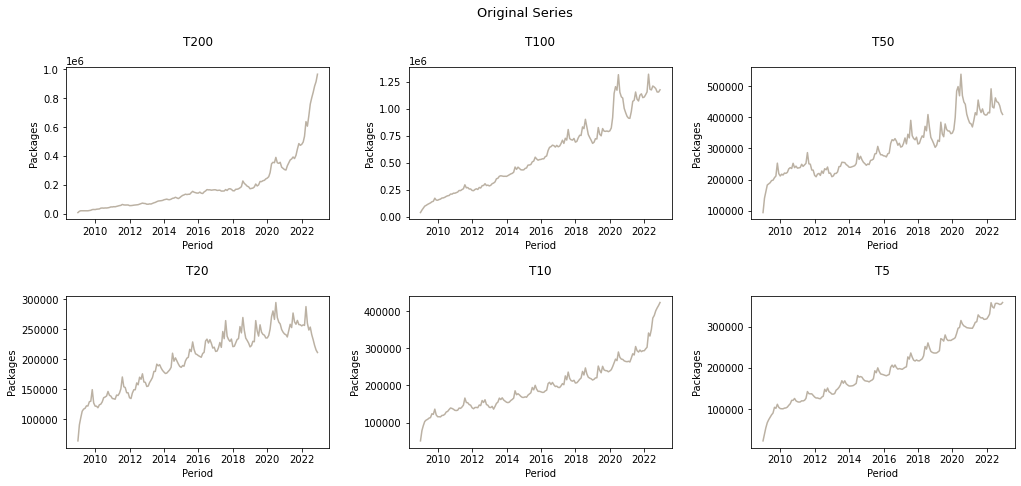

In [7]:
def draw_original_series(df_data_list):
    """Visualize all denomination time series (trend/seasonality check before modeling)."""
    fig, axes = plt.subplots(2, 3, sharex=False, figsize=(17, 7))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    fig.suptitle("Original Series", fontsize=13, y=1.0)

    x_axis = 0
    y_axis = 0
    for data in df_data_list:
        ax = axes[x_axis, y_axis]
        x = data.index
        y = data[data.columns.values[0]]
        ax.plot(x, y, color=color_gray)
        ax.set_title(data.columns.values[0], y=1.1)
        ax.set_xlabel('Period')
        ax.set_ylabel('Packages')
    
        if y_axis < 2:
            y_axis += 1
        else:
            x_axis += 1
            y_axis = 0

    plt.show()

draw_original_series(df_list_date)

## Stationarity Assessment (ADF & KPSS)

In [8]:
def first_diff(diff_df):
    """
    First-order differencing for a single pass.
    Intended to be applied iteratively in a loop for higher orders (2nd, 3rd, ...).
    The initial NaN from the shift is replaced with the mean of the next 5 values
    to preserve series length.
    """
    col = diff_df.columns[0]
    out = diff_df.copy()
    out[col] = out[col] - out[col].shift(1)
    fill_val = out[col].iloc[1:6].mean()
    out[col] = out[col].fillna(fill_val)
    return out

In [9]:
# Stationarity via ADF / KPSS with iterative differencing
PVALUE_THRESH = 0.05
REG_SPECS_ADF  = ['n', 'c', 'ct']   # ADF deterministic terms
REG_SPECS_KPSS = ['c', 'ct']        # KPSS deterministic terms

def _adf_best(y):
    """Return best (lowest p) ADF result across regressions n/c/ct."""
    best = None
    for reg in REG_SPECS_ADF:
        stat, p = adfuller(y, maxlag=None, regression=reg, autolag='AIC', store=False, regresults=False)[:2]
        if (best is None) or (p < best[1]):
            best = (stat, p, reg)
    stat, p, reg = best
    passed = (p < PVALUE_THRESH)  # ADF: p<alpha => stationary
    return stat, p, reg, passed

def _kpss_best(y):
    """Return best (highest p) KPSS result across regressions c/ct."""
    best = None
    for reg in REG_SPECS_KPSS:
        stat, p, *_ = kpss(y, regression=reg, nlags='auto', store=False)
        if (best is None) or (p > best[1]):
            best = (stat, p, reg)
    stat, p, reg = best
    passed = (p > PVALUE_THRESH)  # KPSS: p>alpha => stationary
    return stat, p, reg, passed

def stationarity_table(df_list_onecol, test='adf', max_diff=3, show_reg_note=True):
    """
    Build a stationarity summary table over denominations with iterative differencing.
    Inputs:
      - df_list_onecol: list of single-column DataFrames (DateTimeIndex), e.g. df_train_list_date
      - test: 'adf' or 'kpss'
      - max_diff: try differencing orders 0..max_diff
    Behavior:
      - At each order, run the chosen test using _adf_best/_kpss_best.
      - On first pass that meets the criterion, record and stop for that series.
      - Differencing uses first_diff(...) to keep length (fills initial NaN with mean of next 5).
    """
    test_upper = 'ADF' if test.lower()=='adf' else 'KPSS'
    rows = [
        [f"(0) {test_upper} Statistic"], [f"(0) p-value"], ["(0) Stat./Non-Stat."],
        [f"(1) {test_upper} Statistic"], [f"(1) p-value"], ["(1) Stat./Non-Stat."],
        [f"(2) {test_upper} Statistic"], [f"(2) p-value"], ["(2) Stat./Non-Stat."],
        [f"(3) {test_upper} Statistic"], [f"(3) p-value"], ["(3) Stat./Non-Stat."]
    ]

    kept_stationary_series = []
    for x in df_list_onecol:
        s_curr = x.copy()
        row_idx = 0
        done = False
        order = 0

        for _ in range(max_diff + 1):
            y = s_curr.iloc[:, 0].values  # 1D
            if test.lower() == 'adf':
                stat, p, reg, passed = _adf_best(y)
            else:
                stat, p, reg, passed = _kpss_best(y)

            rows[row_idx].append(f"{stat:.3f}"); row_idx += 1
            rows[row_idx].append(f"{p:.3f}");    row_idx += 1

            if passed:
                short = f"{order}-Stat ({reg})" if show_reg_note else f"{order}-Order Stationary"
                rows[row_idx].append(short)
                kept_stationary_series.append(s_curr)
                # fill remaining cells in this column
                while row_idx < len(rows) - 1:
                    row_idx += 1
                    rows[row_idx].append("")
                done = True
                break
            else:
                rows[row_idx].append("Non-Stationary")
                s_curr = first_diff(s_curr)  # try next differencing order
                order += 1
                row_idx += 1  # spacing between blocks

        # if not resolved, pad remaining cells
        if not done and row_idx < len(rows):
            while row_idx < len(rows):
                rows[row_idx].append("")
                row_idx += 1

    headers = ["(Degree) Statistics"] + denomination_list
    print(tabulate(rows, headers=headers))
    return kept_stationary_series

In [10]:
# Check stationarity per denomination across differencing orders (0..3)
# ADF and KPSS used together for cross-validation of stationarity decision
# Evaluated only on TRAIN subset to avoid leakage from validation/test
# Although auto_arima performs internal differencing, explicit ADF/KPSS validation ensures d/D are consistent and interpretable.

print("\n=== ADF Stationarity Table (Train) ===\n")
stationary_list_ADF = stationarity_table(df_train_list_date, test='adf', max_diff=3, show_reg_note=True)

print("\n" + "-" * 50 + "\n")

print("\n=== KPSS Stationarity Table (Train) ===\n")
stationary_list_KPSS = stationarity_table(df_train_list_date, test='kpss', max_diff=3, show_reg_note=True)



=== ADF Stationarity Table (Train) ===

(Degree) Statistics    T200            T100         T50             T20             T10             T5
---------------------  --------------  -----------  --------------  --------------  --------------  --------------
(0) ADF Statistic      -2.852          -3.721       -2.306          -1.736          -0.819          5.207
(0) p-value            0.179           0.021        0.430           0.735           0.964           1.000
(0) Stat./Non-Stat.    Non-Stationary  0-Stat (ct)  Non-Stationary  Non-Stationary  Non-Stationary  Non-Stationary
(1) ADF Statistic      -3.855                       -1.988          -4.493          -3.964          -6.863
(1) p-value            0.002                        0.045           0.000           0.010           0.000
(1) Stat./Non-Stat.    1-Stat (c)                   1-Stat (n)      1-Stat (c)      1-Stat (ct)     1-Stat (c)
(2) ADF Statistic
(2) p-value
(2) Stat./Non-Stat.
(3) ADF Statistic
(3) p-value
(3) Stat./

## Correlation Analysis: Original vs Differenced Series

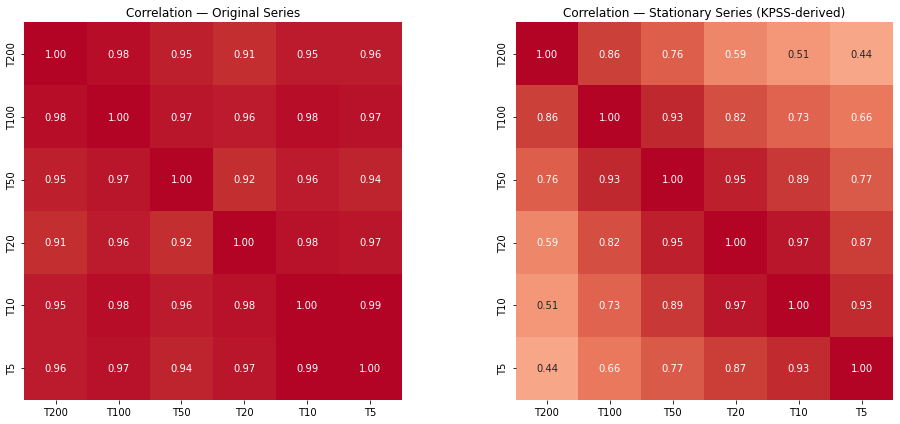

In [11]:
# Compare level-based (original) vs change-based (differenced) correlations 
# to assess whether denominations co-move structurally or only via shared trends

# 1) Original series (non-stationary)
corr_orig = train_df.corr(method="pearson")

# 2) Stationary series from KPSS-based differencing
one_order_stationary = pd.concat(stationary_list_KPSS, axis=1)
corr_stat = one_order_stationary.corr(method="pearson")

# Heatmap plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap 1 - Original
sns.heatmap(corr_orig, ax=axes[0], annot=True, cmap="coolwarm", vmin=-1, vmax=1,
            square=True, cbar=False, fmt=".2f")
axes[0].set_title("Correlation — Original Series", fontsize=12)

# Heatmap 2 - Stationary
sns.heatmap(corr_stat, ax=axes[1], annot=True, cmap="coolwarm", vmin=-1, vmax=1,
            square=True, cbar=False, fmt=".2f")
axes[1].set_title("Correlation — Stationary Series (KPSS-derived)", fontsize=12)

plt.tight_layout()
plt.show()


## Forecast Evaluation Utilities


In [12]:
def plot_forecast_diagnostics(train_actual, eval_actual, model, phase="validation"):
    """
    Plot in-sample fit + out-of-sample forecast with confidence intervals (CIs), 
    residual ACF, and print RMSE/SMAPE/Normalized RMSE (NRMSE).
    """
    
    if phase == "validation":
        phase_title = "Validation"; eval_label = "Actual (Valid)"
    else:
        phase_title = "Test";        eval_label = "Actual (Test)"

    # Accuracy metrics
    def _forecast_accuracy(actual, forecast):
        # Convert dataframe to numpy
        forecast = forecast.to_numpy()
        actual   = actual.to_numpy().reshape(-1)
        # Metrics
        mse  = mean_squared_error(actual, forecast)
        rmse = math.sqrt(mse)
        smape = round(pm.metrics.smape(actual, forecast), 2)
        return round(rmse, 0), round(smape, 2)
    
    # In-sample fit & CIs
    train_pred, conf_tr = model.predict_in_sample(return_conf_int=True)
    train_pred = pd.Series(train_pred, index=train_actual.index)
    conf_tr = pd.DataFrame(conf_tr, index=train_actual.index)

    # Out-of-sample forecast & CIs
    forecast, conf_test = model.predict(n_periods=len(eval_actual), return_conf_int=True)
    forecast = pd.Series(forecast, index=eval_actual.index)
    conf_test = pd.DataFrame(conf_test, index=eval_actual.index)

    # Residuals
    residuals = model.resid().dropna()
    
    # Figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
    fig.suptitle(f"{train_actual.columns[0]} — SARIMA ({phase_title})", fontsize=13, y=0.98)

    # Left: Forecast vs Actual
    ax = axes[0]
    ax.plot(train_actual, color=color_orange, label="Actual (History)")
    ax.plot(train_pred,   color=color_turquoise, label="Model Fit (History)")
    ax.fill_between(train_pred.index, conf_tr.iloc[:,0], conf_tr.iloc[:,1], color=color_gray, alpha=.3)

    ax.plot(eval_actual, color=color_red, label=eval_label)
    ax.plot(forecast,    color=color_blue, label="Forecast")
    ax.fill_between(forecast.index, conf_test.iloc[:,0], conf_test.iloc[:,1], color=color_gray, alpha=.5)

    if len(eval_actual.index) > 0:
        ax.axvline(x=eval_actual.index[0], color=color_gray, ls='--', lw=1)

    ax.set_title("Forecast vs Actual", pad=14)
    ax.set_xlabel("Date"); ax.set_ylabel("Number of Packages")
    ax.legend(loc="upper left", framealpha=0.0)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # Right: Residual ACF
    ax = axes[1]
    plot_acf(residuals, ax=ax, lags=30, title="")
    ax.set_title("Residual Autocorrelation", pad=14)
    ax.set_xlabel("Lag"); ax.set_ylabel("ACF")

    # Styling for ACF bars/lines
    markercolor = color_blue; linecolor = "black"; facecolor = color_gray; barcolor = color_blue; linewidth = 1
    for item in ax.collections:
        if isinstance(item, PolyCollection): item.set_facecolor(facecolor); item.set_alpha(.4)
        if isinstance(item, LineCollection): item.set_color(barcolor)
    for item in ax.lines: item.set_color(markercolor)
    if ax.lines:
        ax.lines[0].set_color(linecolor); ax.lines[0].set_linewidth(linewidth)
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    # Metrics (align indices defensively)
    y_true = eval_actual.iloc[:,0].reindex(forecast.index)
    y_pred = forecast.reindex(y_true.index)
    rmse, smape = _forecast_accuracy(y_true, y_pred)
    mean_level = y_true.mean()
    nrmse = float("nan") if mean_level == 0 else round(rmse / mean_level * 100, 2)

    line = f"==== RESULTS — {train_actual.columns[0]} ({phase_title}) ===="
    print(f"\n{line}\n")
    print(f"{phase_title} RMSE (packages)  : {rmse:,.0f}")
    print(f"{phase_title} SMAPE (0–200)    : {smape:.2f}%")
    print(f"{phase_title} NRMSE (% of mean): {nrmse:.2f}%")
    
    return train_pred, forecast


## SARIMA Model Fitting (Parameter Selection)

In [13]:
def fit_auto_arima(train_actual, params):
    """
    Fit SARIMA model using pmdarima.auto_arima with explicit parameter bounds.
    Exhaustive search (stepwise=False) is used to avoid local minima while 
    retaining control over trend/intercept.
    """
    # Unpack parameters
    (
    start_p, d, start_q,
    max_p, max_d, max_q,
    start_P, D, start_Q,
    max_P, max_D, max_Q,
    max_order, n_fits, 
    with_intercept, trend
    ) = params

    model = pm.auto_arima(
                          train_actual, X=None, 
                          start_p=start_p, d=d, start_q=start_q, 
                          max_p=max_p, max_d=max_d, max_q=max_q, 
                          start_P=start_P, D=D, start_Q=start_Q, 
                          max_P=max_P, max_D=max_D, max_Q=max_Q, 
                          max_order=max_order, m=12, seasonal=True, 
                          stationary=False, information_criterion='aic', 
                          alpha=0.05, test='adf', seasonal_test='ocsb', 
                          stepwise=False, n_jobs=1, start_params=None, 
                          method='lbfgs', maxiter=100, trend=trend, #{‘n’,’c’,’t’,’ct’}
                          offset_test_args=None, seasonal_test_args=None, 
                          suppress_warnings=True, error_action='trace', 
                          trace=False, random=False, random_state=None, 
                          n_fits=n_fits, return_valid_fits=False, out_of_sample_size=0, 
                          scoring='mse', scoring_args=None, with_intercept=with_intercept, #"auto", True, False
                          sarimax_kwargs=None
                         )

    
    print(model.summary())
    return model

## SARIMA Model Refit (Locked Parameters)

In [14]:
def fit_pmdarima_locked(train_valid_actual, val_model):
    """
    Refit SARIMA on train+valid using orders selected on validation (locked order & trend).
    Purpose: freeze (p,d,q)(P,D,Q,m) and trend/intercept from val_model for final evaluation.
    """
    
    p, d, q = val_model.order
    P, D, Q, m = val_model.seasonal_order
    trend = val_model.trend                 # 'n' / 'c' / 't' / 'ct'
    wi = ('c' in trend)                     # intercept iff constant term present

    print(f"Locked order: {p,d,q} x {P,D,Q,m}, trend={trend}, intercept={wi} \n")
    
    model_locked = pm.ARIMA(
        order=(p, d, q),
        seasonal_order=(P, D, Q, m),
        trend=trend,
        with_intercept=wi,
        m=m, seasonal=True,
        suppress_warnings=False
    )
    model_locked.fit(train_valid_actual)
    print(model_locked.summary())
    return model_locked

## End-to-End Run per Denomination


====================================== T200 — VALIDATION ======================================

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1400.016
Date:                              Sun, 05 Oct 2025   AIC                           2808.033
Time:                                      17:42:46   BIC                           2819.533
Sample:                                  01-01-2009   HQIC                          2812.706
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


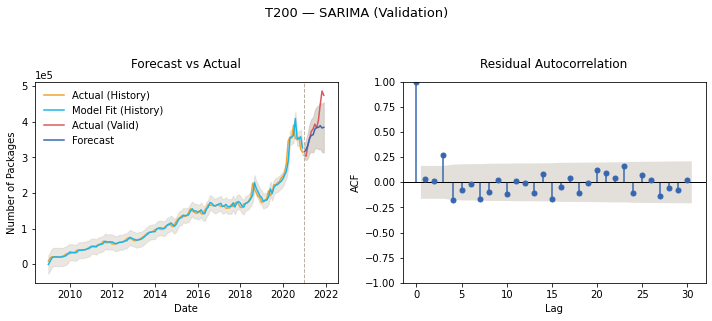


==== RESULTS — T200 (Validation) ====

Validation RMSE (packages)  : 44,492
Validation SMAPE (0–200)    : 7.07%
Validation NRMSE (% of mean): 11.51%

========================================= T200 — TEST =========================================

Locked order: (0, 1, 0) x (0, 1, 1, 12), trend=ct, intercept=True 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1546.849
Date:                              Sun, 05 Oct 2025   AIC                           3101.698
Time:                                      17:42:48   BIC                           3113.549
Sample:                                  01-01-2009   HQIC                          3106.513
                                       - 12-01-2021                                         
Covariance Type:                 

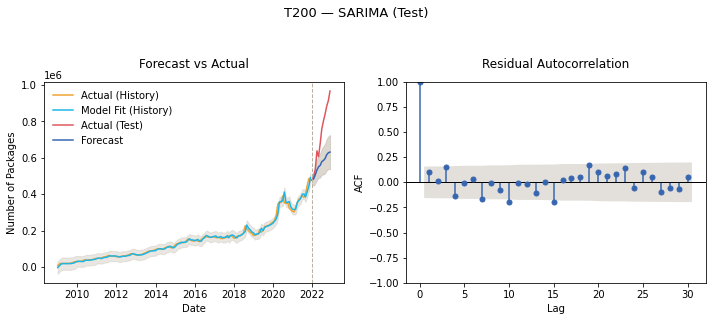


==== RESULTS — T200 (Test) ====

Test RMSE (packages)  : 190,305
Test SMAPE (0–200)    : 21.87%
Test NRMSE (% of mean): 26.52%

====================================== T100 — VALIDATION ======================================

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1582.393
Date:                              Sun, 05 Oct 2025   AIC                           3174.786
Time:                                      17:43:04   BIC                           3189.200
Sample:                                  01-01-2009   HQIC                          3180.643
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std e

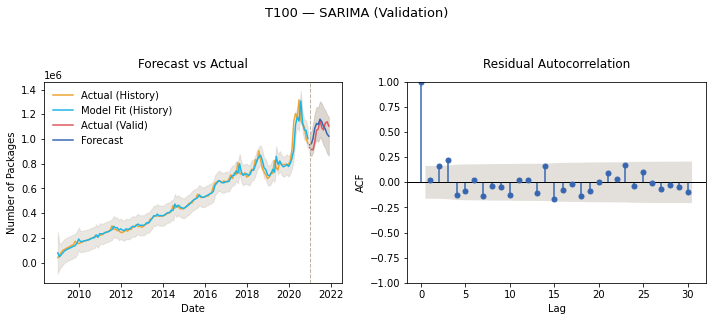


==== RESULTS — T100 (Validation) ====

Validation RMSE (packages)  : 64,399
Validation SMAPE (0–200)    : 5.37%
Validation NRMSE (% of mean): 6.15%

========================================= T100 — TEST =========================================

Locked order: (2, 0, 0) x (0, 1, 1, 12), trend=c, intercept=True 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1729.554
Date:                              Sun, 05 Oct 2025   AIC                           3469.107
Time:                                      17:43:06   BIC                           3483.956
Sample:                                  01-01-2009   HQIC                          3475.141
                                       - 12-01-2021                                         
Covariance Type:                   

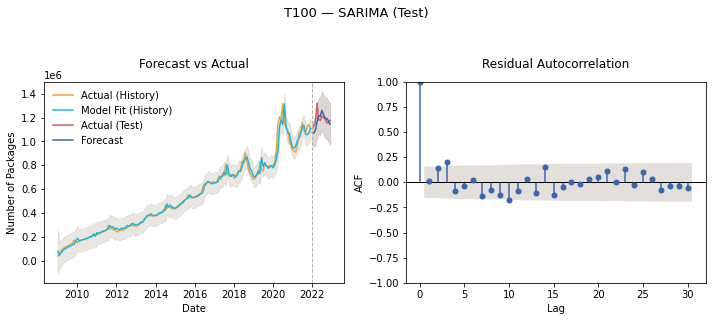


==== RESULTS — T100 (Test) ====

Test RMSE (packages)  : 59,412
Test SMAPE (0–200)    : 3.86%
Test NRMSE (% of mean): 5.03%

====================================== T50 — VALIDATION ======================================

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1494.081
Date:                              Sun, 05 Oct 2025   AIC                           2998.162
Time:                                      17:43:20   BIC                           3012.576
Sample:                                  01-01-2009   HQIC                          3004.019
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err  

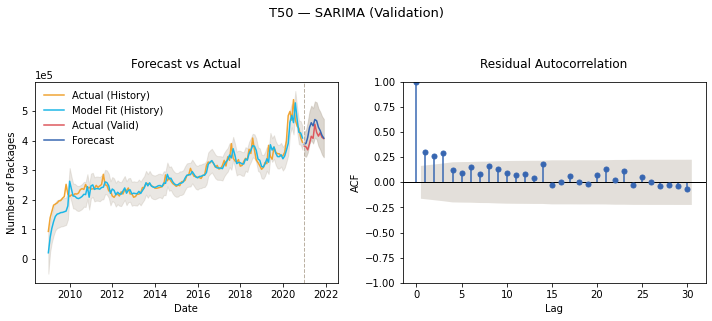


==== RESULTS — T50 (Validation) ====

Validation RMSE (packages)  : 31,080
Validation SMAPE (0–200)    : 5.98%
Validation NRMSE (% of mean): 7.63%

========================================= T50 — TEST =========================================

Locked order: (2, 0, 0) x (0, 1, 1, 12), trend=c, intercept=True 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1630.086
Date:                              Sun, 05 Oct 2025   AIC                           3270.171
Time:                                      17:43:21   BIC                           3285.020
Sample:                                  01-01-2009   HQIC                          3276.205
                                       - 12-01-2021                                         
Covariance Type:                     

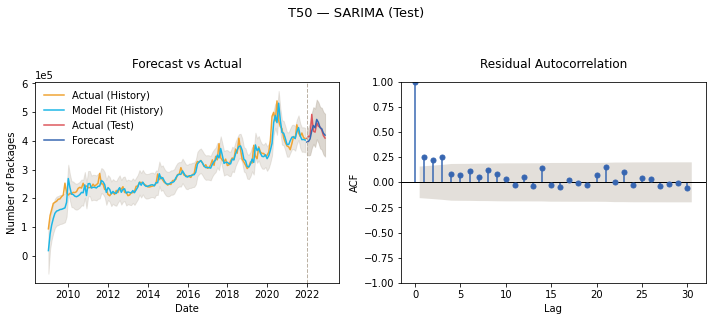


==== RESULTS — T50 (Test) ====

Test RMSE (packages)  : 20,292
Test SMAPE (0–200)    : 3.43%
Test NRMSE (% of mean): 4.66%

====================================== T20 — VALIDATION ======================================

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1383.087
Date:                              Sun, 05 Oct 2025   AIC                           2776.174
Time:                                      17:43:39   BIC                           2790.550
Sample:                                  01-01-2009   HQIC                          2782.016
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err   

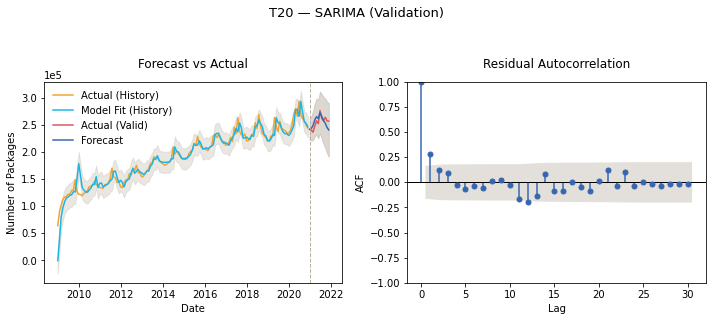


==== RESULTS — T20 (Validation) ====

Validation RMSE (packages)  : 9,166
Validation SMAPE (0–200)    : 3.03%
Validation NRMSE (% of mean): 3.60%

========================================= T20 — TEST =========================================

Locked order: (1, 1, 0) x (1, 1, 1, 12), trend=c, intercept=True 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1506.743
Date:                              Sun, 05 Oct 2025   AIC                           3023.487
Time:                                      17:43:40   BIC                           3038.301
Sample:                                  01-01-2009   HQIC                          3029.506
                                       - 12-01-2021                                         
Covariance Type:                      

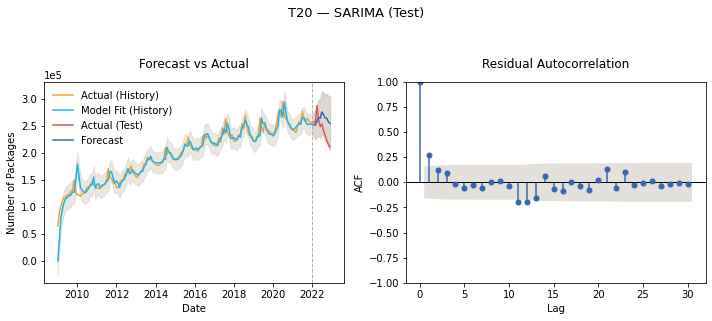


==== RESULTS — T20 (Test) ====

Test RMSE (packages)  : 27,171
Test SMAPE (0–200)    : 9.13%
Test NRMSE (% of mean): 11.08%

====================================== T10 — VALIDATION ======================================

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1352.793
Date:                                 Sun, 05 Oct 2025   AIC                           2717.585
Time:                                         17:44:20   BIC                           2734.836
Sample:                                     01-01-2009   HQIC                          2724.595
                                          - 12-01-2020                                         
Covariance Type:                                   opg                                         
          

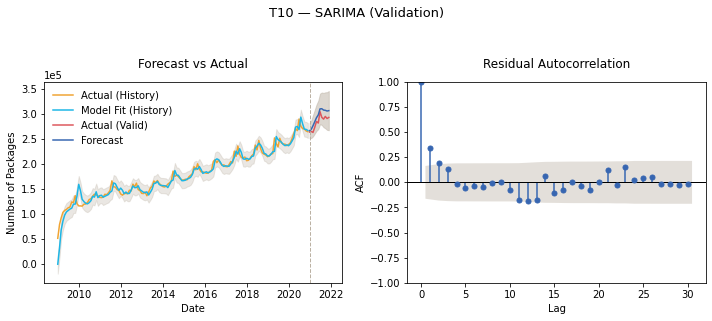


==== RESULTS — T10 (Validation) ====

Validation RMSE (packages)  : 12,528
Validation SMAPE (0–200)    : 3.94%
Validation NRMSE (% of mean): 4.42%

========================================= T10 — TEST =========================================

Locked order: (1, 1, 0) x (0, 1, 2, 12), trend=ct, intercept=True 

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1473.509
Date:                                 Sun, 05 Oct 2025   AIC                           2959.017
Time:                                         17:44:23   BIC                           2976.794
Sample:                                     01-01-2009   HQIC                          2966.241
                                          - 12-01-2021                                         
Covariance Type

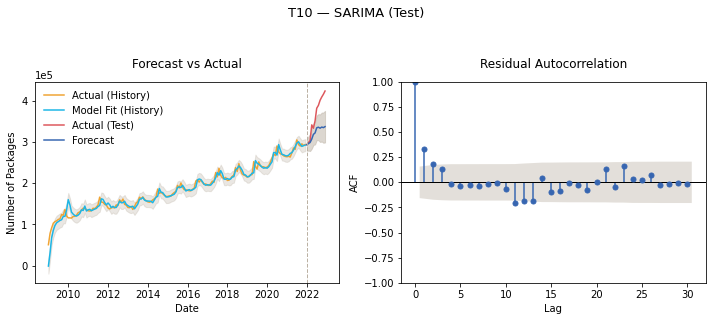


==== RESULTS — T10 (Test) ====

Test RMSE (packages)  : 51,038
Test SMAPE (0–200)    : 11.38%
Test NRMSE (% of mean): 14.11%

====================================== T5 — VALIDATION ======================================

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -1446.169
Date:                                 Sun, 05 Oct 2025   AIC                           2902.337
Time:                                         17:44:33   BIC                           2917.152
Sample:                                     01-01-2009   HQIC                          2908.357
                                          - 12-01-2020                                         
Covariance Type:                                   opg                                         
          

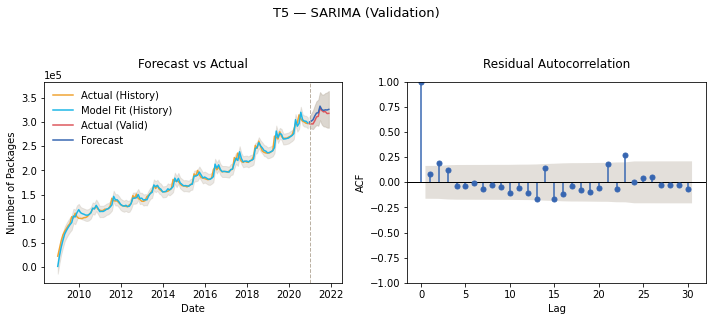


==== RESULTS — T5 (Validation) ====

Validation RMSE (packages)  : 6,491
Validation SMAPE (0–200)    : 1.91%
Validation NRMSE (% of mean): 2.08%

========================================= T5 — TEST =========================================

Locked order: (1, 1, 0) x (0, 0, 2, 12), trend=c, intercept=True 

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -1569.325
Date:                                 Sun, 05 Oct 2025   AIC                           3148.650
Time:                                         17:44:34   BIC                           3163.867
Sample:                                     01-01-2009   HQIC                          3154.830
                                          - 12-01-2021                                         
Covariance Type:   

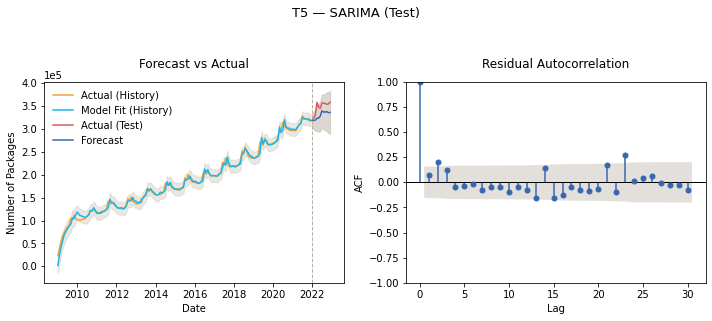


==== RESULTS — T5 (Test) ====

Test RMSE (packages)  : 19,132
Test SMAPE (0–200)    : 5.05%
Test NRMSE (% of mean): 5.52%


In [15]:
# For each denomination: select SARIMA orders on TRAIN, then refit locked model on TRAIN+VALID and evaluate on TEST.
# Parameter bounds differ by denomination (based on stationarity/seasonality diagnostics).

# target selection: run all or a single denomination
selected_denomination = None  # None -> run all; e.g., T200 -> run only T200
targets = [selected_denomination] if selected_denomination else denomination_list

train_map = {
    T200: df200_train_date, T100: df100_train_date, T50: df50_train_date,
    T20: df20_train_date,   T10: df10_train_date,   T5:  df5_train_date
}
valid_map = {
    T200: df200_valid_date, T100: df100_valid_date, T50: df50_valid_date,
    T20: df20_valid_date,   T10: df10_valid_date,   T5:  df5_valid_date
}
test_map = {
    T200: df200_test_date,  T100: df100_test_date,  T50: df50_test_date,
    T20: df20_test_date,    T10: df10_test_date,    T5:  df5_test_date
}
train_valid_map = {
    T200: df200_train_valid_date, T100: df100_train_valid_date, T50: df50_train_valid_date,
    T20: df20_train_valid_date,   T10: df10_train_valid_date,   T5:  df5_train_valid_date
}

for T in targets:
    train_actual = train_map[T]
    valid_actual = valid_map[T]
    test_actual  = test_map[T]
    train_valid_actual = train_valid_map[T]

    # mo: max_order
    # nf: n_fits
    # wi: with_intercept
    # t : trend
                # start    max     start   max
                # p,d,q,   p,d,q,  P,D,Q,  P,D,Q, mo,nf    wi,    t
    if T==T200:
        params = [0,1,0,  3,3,3,  1,1,1,  2,1,2,  3,10,  "auto","ct"]
    elif T==T100:
        params = [0,0,0,  3,3,3,  0,1,0,  2,1,2,  3,10,  "auto","c"]
    elif T==T50:
        params = [0,0,0,  3,3,3,  0,1,0,  2,1,2,  3,10,  "auto","c"]
    elif T==T20:
        params = [0,1,0,  3,3,3,  0,1,0,  2,1,2,  3,10,  "auto","c"]
    elif T==T10:
        params = [0,1,0,  3,3,3,  0,1,0,  2,1,2,  3,10,  "auto","ct"]
    elif T==T5:
        params = [0,1,0,  3,3,3,  0,0,0,  2,1,2,  3,10,  "auto","c"]

    # (1) Validation: select orders via constrained auto_arima on TRAIN
    print(f"\n====================================== {T} — VALIDATION ======================================\n")
    val_model = fit_auto_arima(train_actual, params)
    print("\n")
    train_pred, valid_pred = plot_forecast_diagnostics(train_actual, valid_actual, val_model, phase="validation")

    # (2) Test: refit locked order on TRAIN+VALID, evaluate on TEST
    print(f"\n========================================= {T} — TEST =========================================\n")
    test_model = fit_pmdarima_locked(train_valid_actual, val_model)
    print("\n")
    train_valid_pred, test_pred = plot_forecast_diagnostics(train_valid_actual, test_actual, test_model, phase="test")
